# Train a SNN obeying Dale's Law on the SHD dataset

In this notebook, we demonstrate the training of a 1-hidden-layer SNN obeying Dale's law on the [SHD dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/).

We will introduce the `DalianLayer` class from the `layer` module, and use the `FluctuationDrivenExponentialInitializer` class from the `initializer` module to initialize the Dalian network in the flucutation-driven regime.

In [14]:
# First, imports
import os
import sys
sys.path.append("../../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, ExcInhLIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenExponentialInitializer, FluctuationDrivenCenteredNormalInitializer
from stork.layers import DalianLayer

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [15]:
datadir = "../data/datasets/hdspikes"

#### Specifying dataset parameters

In [16]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None
    )

#### Load and split dataset into train / validation / test

In [17]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [18]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_hidden_layers = 1
nb_classes = 20
nb_exc_neurons = 128      # Number of excitatory neurons in the hidden layer
ei_ratio = 4          # Number of inhibitory neurons = nb_exc_neurons / ei_ratio

# Neuron Parameters
# # # # # # # # # # #
neuron_group = ExcInhLIFGroup

exc_neuron_kwargs = {
    'tau_mem': 20e-3,
    'tau_exc': 10e-3,
    'tau_inh': 5e-3
}
inh_neuron_kwargs = {
    'tau_mem': 10e-3,
    'tau_exc': 10e-3,
    'tau_inh': 5e-3
}
tau_readout = duration

# Training parameters
# # # # # # # # # # #

batch_size = 400
device = torch.device("cuda:1")
dtype = torch.float
lr = 5e-3
nb_epochs = 200

#### SuperSpike and loss function setup

In [19]:

act_fn = stork.activations.SuperSpike
act_fn.beta = beta

loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

#### Optimizer setup

In [20]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [21]:
# Define regularizer parameters (set regularizer strenght to 0 if you don't want to use them)
upperBoundL2Strength = 0.1
upperBoundL2Threshold = 7       # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time

# Define regularizer list
regs = []

regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,
                                        threshold=upperBoundL2Threshold, 
                                        dims=1)
regs.append(regUB)

#### Initializer setup
We initialize in the fluctuation-driven regime with a target membrane potential standard deviation $\sigma_U=1.0$. Additionally, we set the proportion of membrane potential fluctuations driven by feed-forward inputs to $\alpha=0.9$.

In [22]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenExponentialInitializer(
    sigma_u = sigma_u, 
    nu=nu, 
    timestep = dt,
    alpha=0.9
    )

readout_initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u = sigma_u, 
    nu=nu, 
    timestep = dt,
    alpha=0.9
    )

#### Assemble the model

In [23]:
model = RecurrentSpikingModel(
    batch_size,
    nb_time_steps,
    nb_inputs,
    device,
    dtype)
# INPUT LAYER
# # # # # # # # # # # # # # #
input_group = model.add_group(InputGroup(nb_inputs))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYER
# # # # # # # # # # # # # # #

layer = DalianLayer(name = 'Hid. 1', 
                    model = model,
                    size=nb_exc_neurons,
                    ei_ratio=ei_ratio,
                    input_group = upstream_group,
                    recurrent = True,
                    neuron_class = neuron_group,
                    exc_neuron_kwargs = exc_neuron_kwargs,
                    inh_neuron_kwargs = inh_neuron_kwargs,
                    regs = regs,
                    )

# Initialize Parameters
initializer.initialize(layer)

# Set output as input to next layer
upstream_group = layer.output_group

# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=10e-3,
    initial_state=-1e-3))

readout_connection = model.add_connection(Connection(upstream_group, 
                                                     readout_group,
                                                     flatten_input=True))

# Initialize readout connection
readout_initializer.initialize(readout_connection)



#### Configure model for training

In [24]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

## Monitoring activity before training

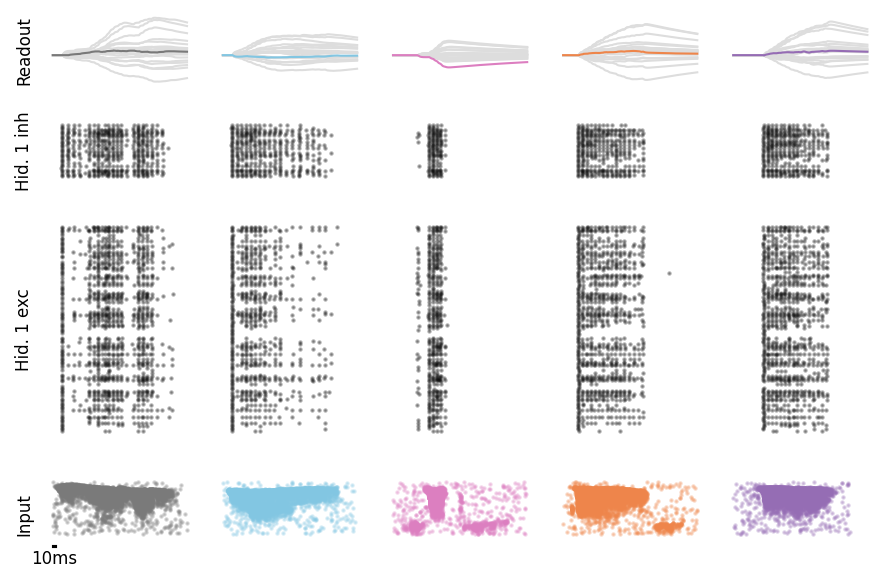

In [25]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)

## Training

takes around 50 Minutes on a GPU

In [26]:
results = {}

history = model.fit_validate(
    train_dataset,
    valid_dataset,
    nb_epochs=nb_epochs,
    verbose=False)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

## Test

In [27]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

#### Visualize performance

Test loss:  1.0895086924235027
Test acc.:  0.6937247474747474

Validation loss:  0.8348276416460673
Validation acc.:  0.7541666666666668


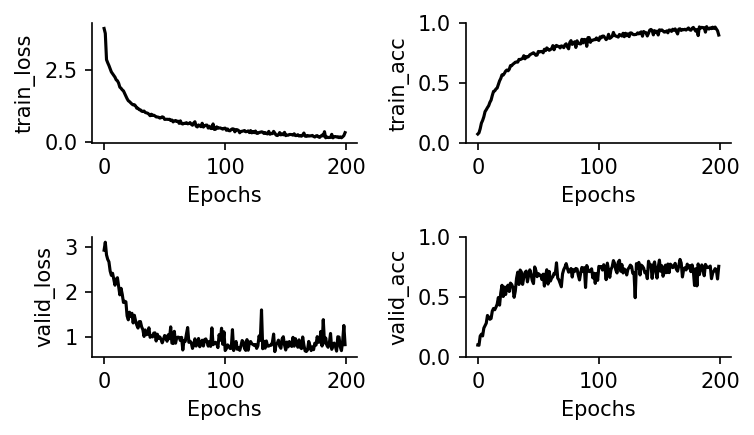

In [28]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

print("\nValidation loss: ", results["valid_loss"][-1])
print("Validation acc.: ", results["valid_acc"][-1])

#### Snapshot after training

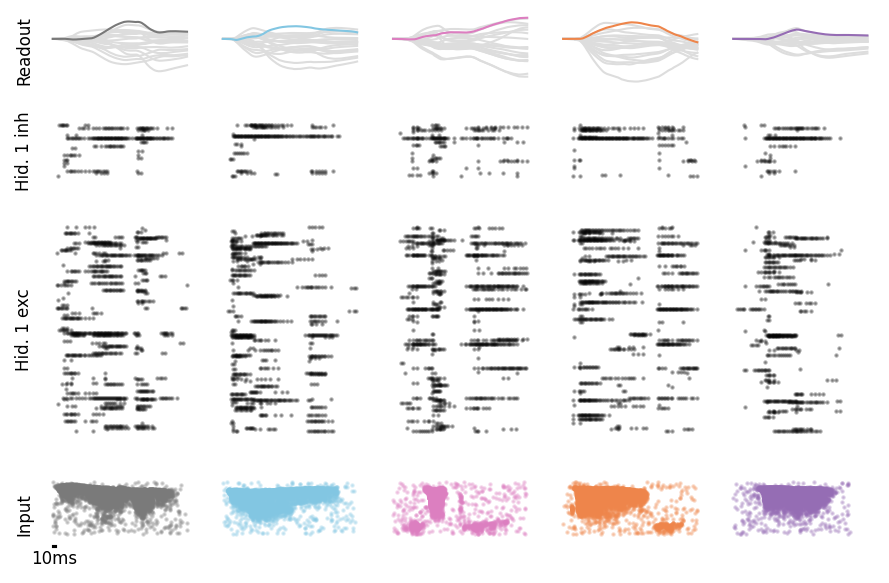

In [29]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)